In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import joblib
import re

# 载入数据
data = pd.read_csv("../../data/new_features.csv")
data.shape

(16000, 380)

In [35]:
def check_column_names(df):
    # 正则表达式匹配字母、数字和下划线以外的字符
    pattern = '[^a-zA-Z0-9_\u4e00-\u9fff]'

    
    for col in df.columns:
        if re.search(pattern, col):
            print(f"列名 '{col}' 包含空格或其他特殊字符。")

# 检查列名
check_column_names(data)

列名 'Unnamed: 0' 包含空格或其他特殊字符。


In [36]:
delete_feature = ['Unnamed: 0','个人编码']
data = data.drop(delete_feature,axis=1)

In [44]:
# 在结尾处获取要删除的特征列表
# data = data.drop(columns=list(features_to_remove))
# data.head()

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,公务员医疗补助基金支付金额_SUM_病种平均费用差,城乡救助补助金额_SUM_病种平均费用差,基本个人账户支付_SUM_病种平均费用差,非账户支付金额_SUM_病种平均费用差,本次审批金额_SUM_病种平均费用差,补助审批金额_SUM_病种平均费用差,医疗救助医院申请_SUM_病种平均费用差,残疾军人补助_SUM_病种平均费用差,一天去两家医院的天数_病种平均费用差,救助_补助金总和
0,0,6,7,5.666667,3,2.166667,34,7,5.666667,3501.18,...,-35.606948,-390.190541,111.135633,-408.616446,-1685.643008,-605.968093,-321.154777,0.000000,-2.950929,NaN
1,0,6,4,2.500000,2,1.333333,15,4,2.500000,2217.66,...,-48.607197,-293.000345,76.149037,-648.154774,-5280.483834,-441.755035,-314.408483,-2.783836,-1.058963,NaN
2,8,6,8,6.166667,3,2.166667,45,9,7.500000,3360.55,...,-35.606948,-390.190541,116.335633,252.393554,-787.653008,-605.968093,-321.154777,0.000000,5.049071,NaN
3,0,6,6,3.666667,2,1.833333,23,6,3.833333,3030.61,...,-48.607197,-293.000345,-50.010963,-520.504774,-2478.013834,-441.755035,-314.408483,-2.783836,-1.058963,NaN
4,0,6,5,4.333333,1,1.000000,26,5,4.333333,2332.45,...,-74.907305,-387.422101,-80.399189,-787.770011,-3412.544432,-575.302137,-455.304614,-9.167719,0.000000,NaN


In [18]:
# # 指定要删除的特征列表
# features_to_drop = ['个人编码', '手术费自费金额_SUM', 'BZ_城乡优抚','交易时间YYYY_NN','住院天数_SUM','高价材料发生金额_SUM',
#                    '成分输血申报金额_SUM','其它申报金额_SUM','最高限额以上金额_SUM','城乡优抚补助_SUM','残疾军人补助_SUM',
#                    '公务员医疗补助基金支付金额_SUM','BZ_民政救助','起付线标准金额_MAX','是否挂号',]

# # 删除这些特征
# data = data.drop(features_to_drop, axis=1)

In [380]:
# # 获取重要性最低的特征
# least_important_features = feature_importances_df.tail(1)

# # 删除这些特征
# data = data.drop(columns=least_important_features['Feature Name'])


In [381]:
# # 保存到CSV文件
# path = 'E:\竞赛\服创赛-A08\data\特征集\lgbm_10_0.92843.csv'
# data.to_csv(path, index=False)


In [28]:
# 分离特征和目标变量
X = data.drop(['RES'], axis=1)
y = data['RES']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### `sampling_strategy` 参数
- **`sampling_strategy`** 参数决定了采样策略。你可以通过它来指定希望欠采样达到的目标比例或数量。其接受的值有几种类型：

  1. **浮点数**：表示多数类样本相对于少数类样本的期望比例。例如，`0.5`表示多数类样本数量将是少数类样本数量的0.5倍。

  2. **字典**：可以为每个目标类别指定采样后的样本数量。例如，`{0: 500, 1: 500}`表示类别0和类别1将各被采样到500个样本。

  3. **字符串**：
     - `'auto'`：自动保留所有少数类样本，而多数类样本则根据其数量进行减少，使其与原先数量最少的类别相同。
     - `'not majority'`：减少多数类样本的数量，直到所有类别的样本数相同。
     - `'all'`：减少所有类的样本数量，直到所有类别的样本数等于最不频繁类别的数量。
     - `'majority'`：只减少多数类的样本数量。

In [29]:
# 计算类别权重
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = {i : weights[i] for i in range(len(weights))}

# 应用Random Under Sampler
rus = RandomUnderSampler(random_state=42,sampling_strategy = {0: 595, 1: 595})
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)


X_train_rus.shape

(1190, 377)

## 额外参数


1. **`boosting_type`**（默认`'gbdt'`）：设置提升类型。可选项包括 `'gbdt'`（传统的梯度提升决策树），`'dart'`（Dropouts meet Multiple Additive Regression Trees），`'goss'`（Gradient-based One-Side Sampling），或`'rf'`（随机森林）。

2. **`num_leaves`**（默认`31`）：一棵树上的叶子节点数量。较大的值可能提高精度，但也可能导致过拟合。

3. **`learning_rate`**（默认`0.1`）：学习速率或步长。较小的值通常需要更多的树来训练模型，但可以提高模型的总体性能。

4. **`subsample`**（默认`1.0`）：控制每棵树的样本比例。值小于1的设置可以防止模型过拟合。

5. **`subsample_freq`**（默认`0`）：决定子样本的频率。如果设置大于0，则会每`subsample_freq`次迭代进行一次子样本。

6. **`colsample_bytree`**（默认`1.0`）：构建每棵树时，列的子样本比例。

7. **`min_child_samples`**（默认`20`）：一个叶子节点所需要的最小样本数。这可以用来防止树过度生长。

8. **`reg_alpha`** 和 **`reg_lambda`**：L1和L2正则化项的系数，有助于防止过拟合。

9. **`objective`**（默认`'binary'`对于二分类）：指定学习任务和相应的学习目标。

10. **`metric`**（默认`'binary_loglos据集和任务进行多次实验来找到最佳的参数组合。

In [30]:
# X_train_rus = X_train
# y_train_rus = y_train

In [31]:
# 构建LightGBM模型
lgbm = LGBMClassifier(random_state=42, 
                      # class_weight=weight_dict,
                      # is_unbalance=True,
                      n_estimators=228,
                      max_depth=-1,
                      # num_leaves = 128,
                      # boosting_type = 'rf',
                      # bagging_freq=1,        # 每一次迭代都进行bagging
                      # bagging_fraction=0.8,  # 每次迭代使用80%的数据
                      # feature_fraction=0.8,   # 每次迭代使用80%的特征
                      # lambda_l2=0.1,
                     )

# 训练模型
lgbm.fit(X_train_rus, y_train_rus)

# 预测
train_preds = lgbm.predict(X_train_rus)
test_preds = lgbm.predict(X_test)
train_proba = lgbm.predict_proba(X_train_rus)[:, 1]
test_proba = lgbm.predict_proba(X_test)[:, 1]



[LightGBM] [Info] Number of positive: 595, number of negative: 595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55481
[LightGBM] [Info] Number of data points in the train set: 1190, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


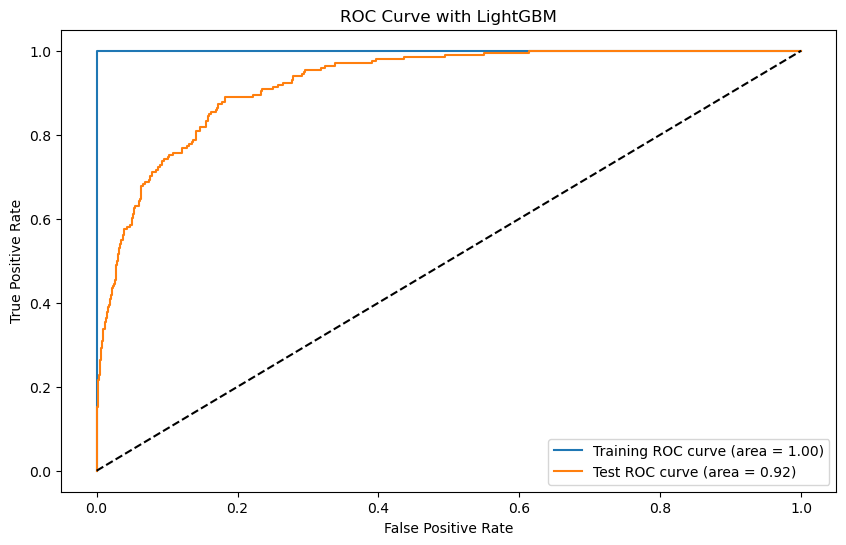

In [8]:
# 性能评估
train_classification_report = classification_report(y_train_rus, train_preds)
test_classification_report = classification_report(y_test, test_preds)
train_roc_auc = roc_auc_score(y_train_rus, train_proba)
test_roc_auc = roc_auc_score(y_test, test_proba)

# 绘制ROC曲线
fpr_train, tpr_train, _ = roc_curve(y_train_rus, train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (area = {train_roc_auc:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with LightGBM')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import classification_report

# Calculate the classification reports
train_classification_report = classification_report(y_train_rus, train_preds)
test_classification_report = classification_report(y_test, test_preds)

# Print the classification reports
print("Training Set Classification Report:\n", train_classification_report)
print("\nTest Set Classification Report:\n", test_classification_report)


Training Set Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       595
           1       1.00      1.00      1.00       595

    accuracy                           1.00      1190
   macro avg       1.00      1.00      1.00      1190
weighted avg       1.00      1.00      1.00      1190


Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      3802
           1       0.21      0.87      0.34       198

    accuracy                           0.83      4000
   macro avg       0.60      0.85      0.62      4000
weighted avg       0.95      0.83      0.87      4000


In [10]:
# 设置阈值
threshold = 0.6

# 以概率形式获取预测结果
y_probs = lgbm.predict_proba(X_test)[:, 1] # 获取正类的概率

# 应用阈值
y_pred_thresh = np.where(y_probs > threshold, 1, 0)

# 生成分类报告
classification_report_06 = classification_report(y_test, y_pred_thresh)

print(classification_report_06)

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3802
           1       0.22      0.85      0.34       198

    accuracy                           0.84      4000
   macro avg       0.60      0.84      0.63      4000
weighted avg       0.95      0.84      0.88      4000


In [11]:
# y_preds = lgbm.predict(X_test)
auc_score = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])

print("Test AUC Score:", auc_score)

Test AUC Score: 0.9237535799871414


In [390]:
from joblib import dump
import joblib

# 保存模型和特征
model_features = {
    'model': lgbm,
    'features': X_train.columns.tolist()
}
joblib.dump(model_features, '../../model_development/models/lgb_model')

['E:\\竞赛\\服创赛-A08\\model\\lgbm\\lgbm_model_2_79524.pkl']

In [391]:
# # 加载模型和特征列表
# loaded_data = joblib.load('model_and_features.pkl')
# model = loaded_data['model']
# features = loaded_data['features']

# # 现在，使用加载的特征列表来准备你的输入数据
# # 假设 df 是要进行预测的新数据集
# df_selected_features = df[features]

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)


from sklearn.feature_selection import mutual_info_classif
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常

import warnings
warnings.filterwarnings("ignore")

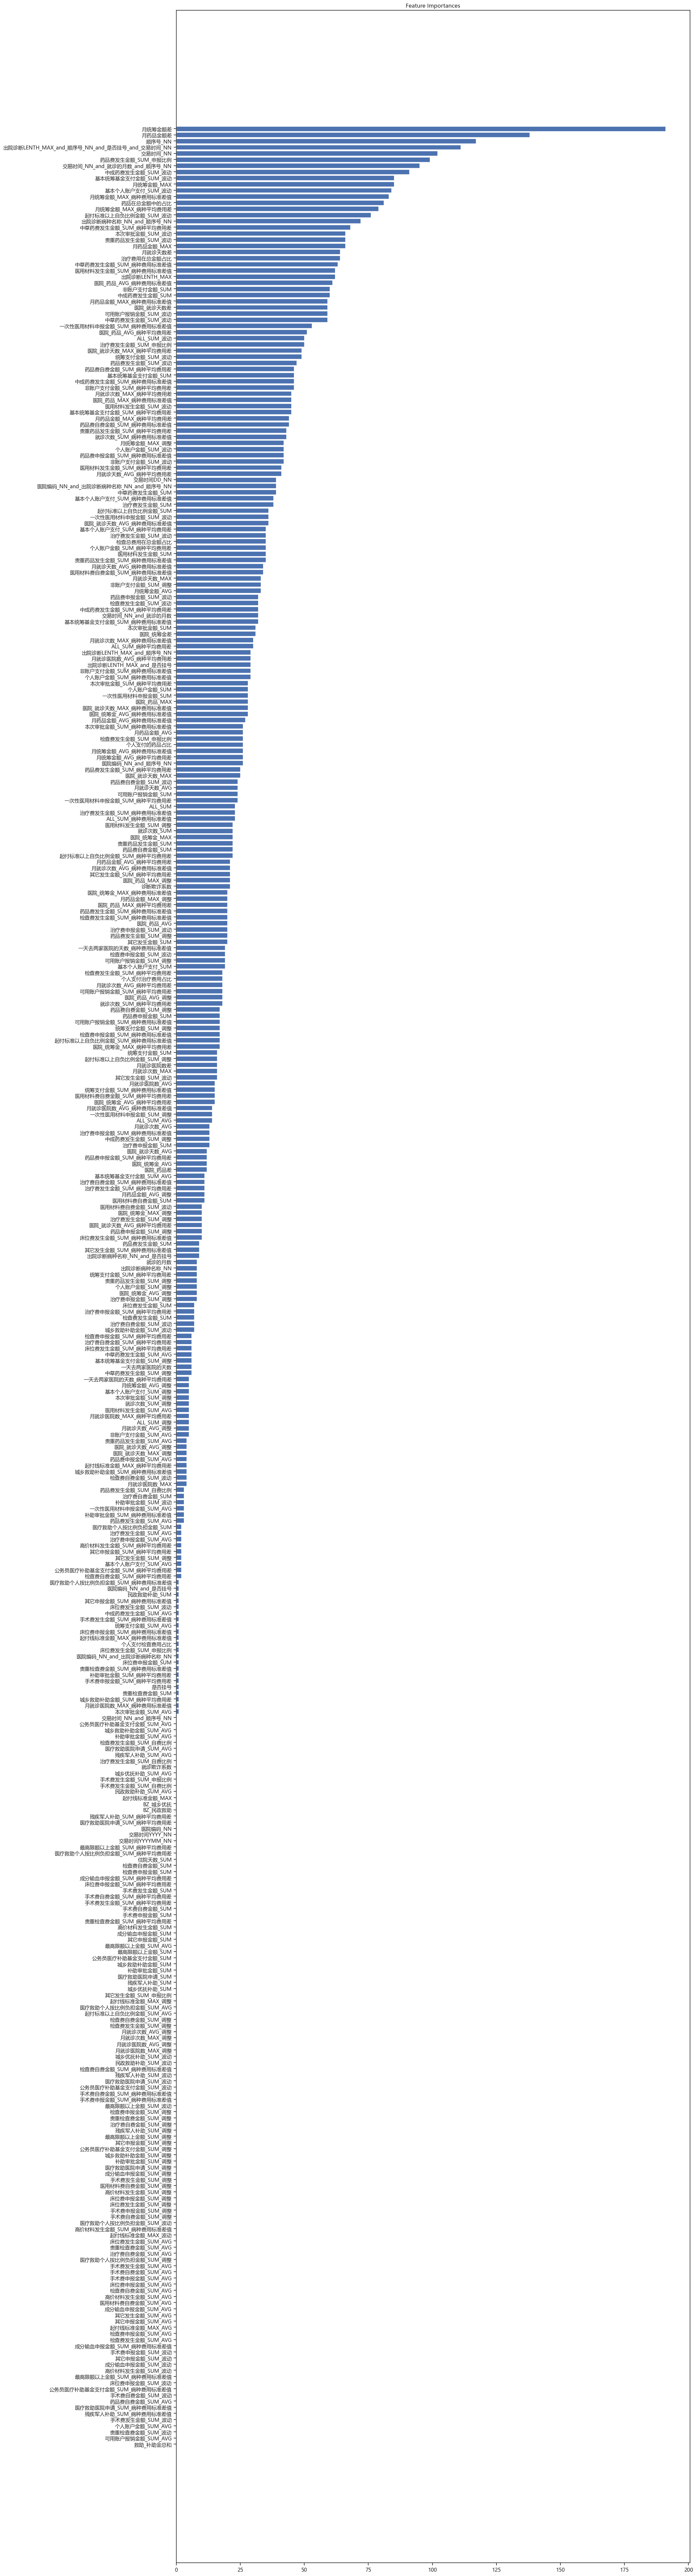

In [20]:
lgb_model = lgbm

# 获取特征重要性
feature_importance = lgb_model.feature_importances_

# 转换为Pandas DataFrame
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature Name': feature_names, 'Importance': feature_importance})

# 对特征重要性进行排序
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(20, 100))
plt.title('Feature Importances')
plt.barh(feature_importances_df['Feature Name'], feature_importances_df['Importance'])
plt.gca().invert_yaxis()
plt.show()

In [21]:
feature_importances_df

,Feature Name,Importance
151,月统筹金额差,191
152,月药品金额差,138
20,顺序号_NN,117
82,出院诊断LENTH_MAX_and_顺序号_NN_and_是否挂号_and_交易时间_NN,111
80,交易时间_NN,102
...,...,...
122,手术费发生金额_SUM_波动,0
273,个人账户金额_SUM_AVG,0
118,贵重检查费金额_SUM_波动,0
276,可用账户报销金额_SUM_AVG,0


In [22]:
high_corr_pairs = []
correlation_matrix = data.corr()
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if (correlation_matrix.loc[row, col] > 0.9) and (col != row):
            # Check if the pair is already added
            if not {(row, col), (col, row)}.intersection(set(high_corr_pairs)):
                high_corr_pairs.append((row, col))

high_corr_pairs

[('一天去两家医院的天数_病种费用标准差值', '一天去两家医院的天数'),
 ('交易时间YYYYMM_NN', '就诊的月数'),
 ('月就诊天数_AVG', '月就诊天数_MAX'),
 ('就诊次数_SUM', '月就诊天数_MAX'),
 ('月就诊次数_MAX', '月就诊天数_MAX'),
 ('月就诊次数_AVG', '月就诊天数_MAX'),
 ('交易时间DD_NN', '月就诊天数_MAX'),
 ('月就诊天数_AVG_调整', '月就诊天数_MAX'),
 ('就诊次数_SUM_调整', '月就诊天数_MAX'),
 ('月就诊次数_MAX_调整', '月就诊天数_MAX'),
 ('月就诊次数_AVG_调整', '月就诊天数_MAX'),
 ('月就诊天数_AVG_病种费用标准差值', '月就诊天数_MAX'),
 ('就诊次数_SUM_病种费用标准差值', '月就诊天数_MAX'),
 ('月就诊次数_MAX_病种费用标准差值', '月就诊天数_MAX'),
 ('月就诊次数_AVG_病种费用标准差值', '月就诊天数_MAX'),
 ('就诊次数_SUM', '月就诊天数_AVG'),
 ('月就诊次数_MAX', '月就诊天数_AVG'),
 ('月就诊次数_AVG', '月就诊天数_AVG'),
 ('交易时间DD_NN', '月就诊天数_AVG'),
 ('月就诊天数_AVG_调整', '月就诊天数_AVG'),
 ('就诊次数_SUM_调整', '月就诊天数_AVG'),
 ('月就诊次数_MAX_调整', '月就诊天数_AVG'),
 ('月就诊次数_AVG_调整', '月就诊天数_AVG'),
 ('月就诊天数_AVG_病种费用标准差值', '月就诊天数_AVG'),
 ('就诊次数_SUM_病种费用标准差值', '月就诊天数_AVG'),
 ('月就诊次数_MAX_病种费用标准差值', '月就诊天数_AVG'),
 ('月就诊次数_AVG_病种费用标准差值', '月就诊天数_AVG'),
 ('月就诊天数_AVG_病种平均费用差', '月就诊天数_AVG'),
 ('就诊次数_SUM_病种平均费用差', '月就诊天数_AVG'),
 ('月就诊次数_AVG_病种平均费用差', '月就诊天数_AVG'),
 ('月就诊

In [23]:
# 初始化要删除的特征列表
# 特征a与特征b高度相关，但是特征a的特征重要性大于b，那么就删除特征b
features_to_remove = set()

for feature1, feature2 in high_corr_pairs:
    # 获取两个特征的重要性
    importance_feature1 = feature_importances_df[feature_importances_df['Feature Name'] == feature1]['Importance'].values[0]
    importance_feature2 = feature_importances_df[feature_importances_df['Feature Name'] == feature2]['Importance'].values[0]

    # 比较重要性并添加较低的一个到删除列表
    if importance_feature1 > importance_feature2:
        features_to_remove.add(feature2)
    else:
        features_to_remove.add(feature1)

# 输出要删除的特征列表
features_to_remove

{'ALL_SUM',
 'ALL_SUM_AVG',
 'ALL_SUM_波动',
 'ALL_SUM_病种平均费用差',
 'ALL_SUM_病种费用标准差值',
 'ALL_SUM_调整',
 '一天去两家医院的天数',
 '一天去两家医院的天数_病种平均费用差',
 '一次性医用材料申报金额_SUM',
 '一次性医用材料申报金额_SUM_AVG',
 '一次性医用材料申报金额_SUM_波动',
 '一次性医用材料申报金额_SUM_病种平均费用差',
 '一次性医用材料申报金额_SUM_病种费用标准差值',
 '一次性医用材料申报金额_SUM_调整',
 '个人账户金额_SUM',
 '个人账户金额_SUM_AVG',
 '个人账户金额_SUM_波动',
 '个人账户金额_SUM_病种平均费用差',
 '个人账户金额_SUM_病种费用标准差值',
 '个人账户金额_SUM_调整',
 '中成药费发生金额_SUM_AVG',
 '中成药费发生金额_SUM_病种平均费用差',
 '中成药费发生金额_SUM_病种费用标准差值',
 '中成药费发生金额_SUM_调整',
 '中草药费发生金额_SUM',
 '中草药费发生金额_SUM_AVG',
 '中草药费发生金额_SUM_病种费用标准差值',
 '中草药费发生金额_SUM_调整',
 '交易时间DD_NN',
 '交易时间YYYYMM_NN',
 '交易时间_NN_and_顺序号_NN',
 '公务员医疗补助基金支付金额_SUM',
 '公务员医疗补助基金支付金额_SUM_AVG',
 '公务员医疗补助基金支付金额_SUM_病种费用标准差值',
 '公务员医疗补助基金支付金额_SUM_调整',
 '其它发生金额_SUM',
 '其它发生金额_SUM_AVG',
 '其它发生金额_SUM_调整',
 '其它申报金额_SUM',
 '其它申报金额_SUM_AVG',
 '其它申报金额_SUM_波动',
 '其它申报金额_SUM_调整',
 '出院诊断LENTH_MAX_and_是否挂号',
 '出院诊断LENTH_MAX_and_顺序号_NN',
 '出院诊断病种名称_NN_and_是否挂号',
 '医用材料发生金额_SUM',
 '医用材料发生金额_SUM_AVG',
 '医用材料发生金额_SUM_病种平均费用差'

In [32]:
# 自动逐步删除不重要特征

for iteration in range(115):  # Adjust the number of iterations as needed

    X = data.drop('RES', axis=1)
    y = data['RES']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    rus = RandomUnderSampler(random_state=42,sampling_strategy = {0: 2000, 1: 556})
    X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
                     
    lgbm.fit(X_train_rus, y_train_rus)

    # 预测
    train_preds = lgbm.predict(X_train_rus)
    test_preds = lgbm.predict(X_test)
    train_proba = lgbm.predict_proba(X_train_rus)[:, 1]
    test_proba = lgbm.predict_proba(X_test)[:, 1]

    # 性能评估
    train_classification_report = classification_report(y_train_rus, train_preds)
    test_classification_report = classification_report(y_test, test_preds)
    train_roc_auc = roc_auc_score(y_train_rus, train_proba)
    test_roc_auc = roc_auc_score(y_test, test_proba)

    auc_score = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])
    
    num_features = len(X_train.columns)
    filename = f'lgbm_{num_features}_{auc_score:.5f}.pkl'  # Filename format


    model_features = {
        'model': lgbm,
        'features': X_train_rus.columns.tolist()
    }
    joblib.dump(model_features, f'E:\竞赛\\服创赛-A08\\model\\DEMO_LGBM\\{filename}')
    


    feature_importance = lgbm.feature_importances_
    feature_names = X_train_rus.columns
    feature_importances_df = pd.DataFrame({'Feature Name': feature_names, 'Importance': feature_importance})
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=True)

    features_to_remove = feature_importances_df.head(1)['Feature Name'].tolist()
    
    #在第一次，根据相关性和排名删除特征--可选
    if iteration==0:
        high_corr_pairs = []
        correlation_matrix = data.corr()
        for col in correlation_matrix.columns:
            for row in correlation_matrix.index:
                if (correlation_matrix.loc[row, col] > 0.9) and (col != row):
                    # Check if the pair is already added
                    if not {(row, col), (col, row)}.intersection(set(high_corr_pairs)):
                        high_corr_pairs.append((row, col))

        features_to_removes = set()

        for feature1, feature2 in high_corr_pairs:

            importance_feature1 = feature_importances_df[feature_importances_df['Feature Name'] == feature1]['Importance'].values[0]
            importance_feature2 = feature_importances_df[feature_importances_df['Feature Name'] == feature2]['Importance'].values[0]
        

            if importance_feature1 > importance_feature2:
                features_to_removes.add(feature2)
            else:
                features_to_removes.add(feature1)

        data = data.drop(columns=list(features_to_removes))
        
    else:
        data = data.drop(columns=features_to_remove)


    print(f"Iteration {iteration+1}: Model trained and saved. Removed features: {features_to_remove}")
    

[LightGBM] [Info] Number of positive: 595, number of negative: 595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55481
[LightGBM] [Info] Number of data points in the train set: 1190, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Iteration 1: Model trained and saved. Removed features: ['救助_补助金总和']
[LightGBM] [Info] Number of positive: 595, number of negative: 595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55481
[LightGBM] [Info] Number of data points in the train set: 1190, number of used fe

KeyError: "['救助_补助金总和'] not found in axis"

In [12]:
# 加载模型和特征列表
loaded_data = joblib.load("../../model_development/models/lgb_model/lgbm_11_0.92571.pkl")
rf_model = loaded_data['model']
rf_features = loaded_data['features']

rf_selected_features = data[rf_features]
rf_selected_features

,月就诊天数_AVG,月统筹金额_MAX,医院_药品_MAX,顺序号_NN,个人账户金额_SUM,本次审批金额_SUM,月药品金额差
0,5.666667,3501.18,8522.57,69,1970.99,16942.04,1206.158333
1,2.500000,2217.66,10309.64,64,1371.57,10915.75,665.976667
2,6.166667,3360.55,10760.51,102,2637.20,17840.03,933.531667
3,3.666667,3030.61,5504.60,56,1373.06,13718.22,451.390000
4,4.333333,2332.45,14507.54,64,1569.65,14642.13,145.336667
...,...,...,...,...,...,...,...
15995,6.500000,2831.13,7808.41,80,1496.13,14263.44,764.685000
15996,6.833333,2369.03,8650.76,85,750.84,11995.70,270.420000
15997,6.333333,5421.56,12665.65,89,3025.40,26504.62,1432.310000
15998,3.333333,5270.74,26037.31,67,4658.08,24766.48,1949.668333


In [37]:
# 加载模型和特征列表
loaded_data = joblib.load("../../model_development/models/lgb_model/lgbm_19_0.92557.pkl")
rf_model = loaded_data['model']
rf_features = loaded_data['features']

rf_selected_features = data[rf_features]
rf_selected_features

,顺序号_NN,中成药费发生金额_SUM,基本统筹基金支付金额_SUM,非账户支付金额_SUM,治疗费用在总金额占比,交易时间_NN,出院诊断LENTH_MAX_and_顺序号_NN_and_是否挂号_and_交易时间_NN,交易时间_NN_and_就诊的月数_and_顺序号_NN,药品费发生金额_SUM_申报比例,可用账户报销金额_SUM_波动,医用材料发生金额_SUM_波动,基本统筹基金支付金额_SUM_波动,月统筹金额差,月药品金额差,月统筹金额_MAX_病种费用标准差值,医院_药品_AVG_病种费用标准差值,一次性医用材料申报金额_SUM_病种费用标准差值,医院_就诊天数_MAX_病种平均费用差,中草药费发生金额_SUM_病种平均费用差
0,69,4776.49,15247.76,1742.19,0.007434,263,8322,2393,0.984992,54.942941,0.294118,448.463529,959.886667,1206.158333,1045.390113,-3281.465868,-544.413278,-5.593014,-2553.937616
1,64,1132.45,9824.15,1172.07,0.013398,232,3949,1096,0.973832,89.311333,0.120000,654.943333,580.301667,665.976667,-794.885302,-2902.155031,-759.346725,-12.282674,-2398.976320
2,102,3762.15,15498.32,2403.20,0.195087,266,8002,2568,0.979995,58.250667,6.670000,344.407111,777.496667,933.531667,904.760113,-3934.992534,-254.263278,-2.593014,-2553.937616
3,56,5075.85,12346.32,1299.72,0.541351,251,2248,1541,0.999816,59.647826,0.000000,536.796522,972.890000,451.390000,18.064698,-5105.425031,-761.146725,-8.282674,-2398.976320
4,64,3678.72,13177.89,1505.65,0.016274,255,10161,1821,0.992734,60.194615,0.000000,506.841923,136.135000,145.336667,-4403.366112,4099.655868,-365.542643,-2.617453,-2184.717175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,80,7368.67,12837.08,1496.13,0.013326,268,7906,2756,0.995067,37.217250,0.000000,320.927000,691.616667,764.685000,375.340113,-3957.979201,-554.413278,-6.593014,-2553.937616
15996,85,2538.32,10196.33,605.78,0.039553,270,6528,2909,0.995028,17.658810,6.914286,242.769762,298.805000,270.420000,-643.515302,-2661.925031,-470.746725,2.717326,-2398.976320
15997,89,3893.34,23854.12,2829.40,0.223888,267,9080,2697,0.985430,66.983333,0.000000,567.955238,1445.873333,1432.310000,2409.014698,2143.144969,-761.146725,-1.282674,4237.193680
15998,67,784.45,22266.53,4481.64,0.006425,249,13923,1427,0.919019,232.048000,1.215000,1113.326500,1559.651667,1949.668333,-1465.076112,15629.425868,-358.342643,-8.617453,-2184.717175
